# Defining a custom surface texture for ray-tracing

This example shows how to define a surface texture from user input, either from 1D lists of
x, y and z coordinates for each point on the surface, or from a 2D matrix specifying surface
heights on a regular grid.

First, we generate a random surface texture in the form of a 20 by 20 matrix. We generate the x
and y coordinates between 0 and 10 um (the chosen width of the texture).

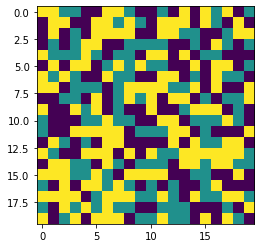

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rayflare.textures import xyz_texture, heights_texture, planar_surface
from rayflare.ray_tracing import rt_structure
from rayflare.options import default_options
from rayflare.transfer_matrix_method import tmm_structure

from solcore import material
from solcore.structure import Layer

x_in = np.linspace(0, 10, 20)
y_in = np.linspace(0, 10, 20)

X, Y = np.meshgrid(x_in, y_in)

# generate a random surface texture
Z = np.random.randint(low=0, high=3, size=(len(x_in), len(y_in)))

plt.figure()
plt.imshow(Z)
plt.show()

Now we can define the texture in two ways: using coordinate lists and xyz_texture, or by providing
the matrix of surface points and specifying the extent of the x and y axes. Both are shown here
for the same random texture.

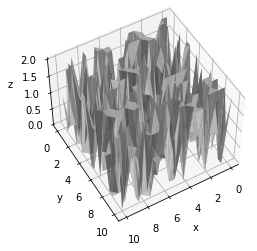

In [2]:
x = X.flatten()
y = Y.flatten()
z = Z.flatten()

# xyz_texture takes a 1D numpy array/list of x, y and z coordinates
random_surf = xyz_texture(x, y, z)

# can also use heights_texture; this takes a 2D array of z coordinates and
# the extent of the x and y axes
random_surf_2 = heights_texture(Z, np.max(x_in), np.max(y_in))

# random_surf and random_surf_2 are identical

[front, back] = random_surf

fig = plt.figure()
ax = plt.subplot(projection='3d')
ax.view_init(elev=50., azim=60)
ax.plot_trisurf(front.Points[:,0], front.Points[:,1], front.Points[:,2],
                triangles=front.simplices,  linewidth=1, color = (0.8, 0.8, 0.8, 0.8))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

Now we define a planar surface (for the rear of the structure) and define a simple 200 micron
Si slab with the random texture on the front and a planar rear and do ray-tracing to calculate
absorption, reflection and transmission.

In [3]:
flat_surf = planar_surface(size=20)  # pyramid size in microns

Air = material('Air')()
Si = material('Si')()

wavelengths = np.linspace(300, 1190, 20)*1e-9

options = default_options()
options.n_rays = 1000
options.wavelengths = wavelengths

# set up ray-tracing options
rtstr = rt_structure(textures=[random_surf, flat_surf],
                     materials=[Si],
                     widths=[200e-6], incidence=Air, transmission=Air)
result = rtstr.calculate(options)

To compare, we also calculate what the absorption would be in a completely planar slab of 200
microns of Si, using the TMM method. We expect that absorption is higher in the textured case,
and reflection and transmission are lower. We also plot the average number of interactions with
the front and back surfaces and the average number of passes through the bulk for the randomly
textured case.

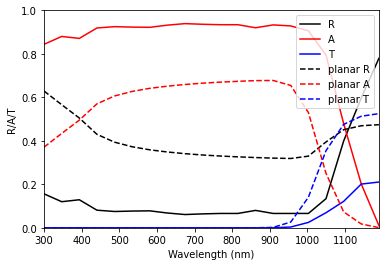

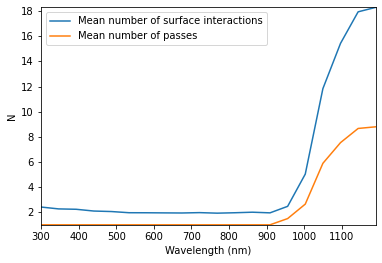

In [4]:
options.coherent = False
options.coherency_list = ['i']
planar_struct = tmm_structure([Layer(200e-6, Si)], incidence=Air, transmission=Air)
result_planar = planar_struct.calculate(options)

plt.figure()
plt.plot(wavelengths*1e9, result['R'], '-k', label='R')
plt.plot(wavelengths*1e9, result['A_per_layer'][:,0], '-r', label='A')
plt.plot(wavelengths*1e9, result['T'], '-b', label='T')
plt.plot(wavelengths*1e9, result_planar['R'], '--k', label='planar R')
plt.plot(wavelengths*1e9, result_planar['A_per_layer'][:,0], '--r', label='planar A')
plt.plot(wavelengths*1e9, result_planar['T'], '--b', label='planar T')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('R/A/T')
plt.autoscale(tight=True)
plt.ylim(0,1)
plt.show()

plt.figure()
plt.plot(wavelengths*1e9, np.mean(result['n_interactions'], 1),
         label='Mean number of surface interactions')
plt.plot(wavelengths*1e9, np.mean(result['n_passes'], 1),
         label='Mean number of passes')
plt.xlabel('Wavelength (nm)')
plt.ylabel('N')
plt.autoscale(tight=True)
plt.legend()
plt.show()